# Reproducing Jamie's analysis and testing  figures

Some of the code below was written by Jamie Griffith.  I am testing that here.  

I am also using this notebook as a testing ground for figures that could be included in the dashboard.

In [3]:
library(lurn)
library(ggplot2)
library(GGally)
library(gt)
library(ggradar)
library(viridis)
library(dplyr)
library(tidyr)
library(cowplot)
library(gridExtra)
library(magick)
library(ggnewscale)
library(stringr)
library(lubridate)

options(jupyter.plot_mimetypes = "image/png", repr.plot.width = 7, repr.plot.height = 6., repr.plot.res = 300)

In [ ]:
# read in all the data 

# for renaming columns
splom_vars <- c(
   "lurn_si_29_total_score", 
   "lurn_si_29_incontinence_score",
   "lurn_si_29_pain_score", 
   "lurn_si_29_voiding_score",
   "lurn_si_29_urgency_score", 
   "lurn_si_29_nocturia_score",
   "lurn_si_29_bother")
symptoms <- c("Total", 
    "Incontinence", 
    "Pain", 
    "Voiding", 
    "Urgency", 
    "Nocturia", 
    "Bother"
)
splom_vars <- rev(splom_vars)
symptoms <- rev(symptoms)


# read in the time series file
syn_long <- read.csv("../data/syn_long.csv", header = TRUE)
patient_cells <- list()
syn_long$ID <- factor(syn_long$ID)
syn_long_dat <- syn_long[c("ID", "Week", splom_vars)]
names(syn_long_dat)<- append(c("ID", "Week"), symptoms)


# define the input_params (add patient_row)
patient_id <- 100
patient_week <- 12

# grab the appropriate week for the current symptoms plot
syn_week <- syn_long[syn_long$Week == patient_week, ]
syn_week_dat <- syn_long_dat[syn_long_dat$Week == patient_week, ]

input_params <- list(
    patient_week = patient_week,
    patient_id = patient_id, 
    patient_row = which(syn_week_dat$ID == patient_id)[1]
)

# Rescale bother to 0-100
syn_week_dat$Bother <- syn_week_dat$Bother/3*100
syn_long_dat$Bother <- syn_long_dat$Bother/3*100

# # Function to rescale a column to a specific range
# # what about NaN??
# rescale_to_range <- function(x, new_min, new_max) {
#     scaled <- (x - min(x, na.rm = TRUE))/(max(x, na.rm = TRUE) - min(x, na.rm = TRUE))  # Scale to range [0, 1]
#     scaled_rescaled <- ifelse(is.na(x), 0, scaled*(new_max - new_min) + new_min)  # Rescale to new range
#     return(scaled_rescaled)
# }
# syn_week_dat$Bother <- rescale_to_range(syn_week_dat$Bother, 0, 100)
# syn_long_dat$Bother <- rescale_to_range(syn_long_dat$Bother, 0, 100)


In [ ]:
syn <- read.csv("../data/LURN_SI29_Synth_Final_NoFmt.csv", header = TRUE)
names(syn)[names(syn) == "Sex"] <- "SEX"
syn <- score_lurn_si_29(syn)
colnames(syn)

In [ ]:
splom_vars <- c(
   "lurn_si_29_total_score", "lurn_si_29_incontinence_score",
   "lurn_si_29_pain_score", "lurn_si_29_voiding_score",
   "lurn_si_29_urgency_score", "lurn_si_29_nocturia_score",
   "lurn_si_29_bother")

splom_dat <- syn[splom_vars]
names(splom_dat)<- c("Total","Incontinence", "Pain", "Voiding", "Urgency", "Nocturia", "Bother")
colnames(splom_dat)
head(splom_dat)

In [ ]:
ggpairs(
    splom_dat,
    lower = list(continuous = wrap("smooth_loess", alpha = 1 / 10)),
    columnLabels = c("Total", "Incontinence", "Pain", "Voiding", "Urgency",
    "Nocturia", "Bother"),
    title = "Scatterplot matrix (SPLOM) of LURN SI-29 scales: Synthetic data"
) +
theme_bw()

In [ ]:
ggplot(splom_dat, aes(x = Voiding)) + geom_density()

In [ ]:
si_29_m_nms <- lurn_si_29_names("male")
si29_prelim_freq_table <- t(apply(syn[si_29_m_nms],
                                  2,
                                  function(x) table(factor(x, levels = 0:4),
                                                    useNA = "always")))

si29_prelim_prop_table <- prop.table(si29_prelim_freq_table, margin = 1)

colnames(si29_prelim_prop_table) <- c("0", "1", "2", "3", "4", "Missing")

si29_prelim_freq_table

In [ ]:
this_patient_row <- syn[100, si_29_m_nms]
this_patient_row

In [ ]:
syn[, si_29_m_nms[1]]

In [ ]:
for (cc in si_29_m_nms){
    print(median(syn[, cc], na.rm = TRUE))
}

## Long file

### Spaghetti plot

In [ ]:
syn_long <- read.csv("../data/syn_long.csv", header = TRUE)
patient_cells <- list()
syn_long$ID <- factor(syn_long$ID)

breaks <- seq(0, 24, 4)
labels <- c("0\nbaseline", "4\n(post-surgery)", "8", "12", "16", "20", "24")

# Spaghetti Plots
ggplot(data = syn_long,
                   aes(Week,
                       lurn_si_29_total_score,
                       group = ID,
                       colour = ID)) +
  geom_line(show.legend = FALSE) +
  geom_smooth(data = syn_long,
              aes(Week,
                  lurn_si_29_total_score),
              method = "loess",
    show.legend = FALSE,
    se = TRUE,
    inherit.aes = FALSE,
    color = "black") + 
  scale_y_continuous("LURN SI-29 Total", limits = c(0, 100)) +
  scale_x_continuous(breaks = breaks, labels = labels) +
  ggtitle("Spaghetti plot with loess smoother")

In [ ]:
head(syn_long)

### radar plot

In [ ]:
colnames(syn_long)
id = 3
patient_long <- syn_long[syn_long$ID == id, ]

patient_radar_data <- patient_long[c("Week",splom_vars)]
patient_radar_data$Week <- as.factor(patient_radar_data$Week)
names(patient_radar_data)<- c("Time", "Total","Incontinence", "Pain", "Voiding", "Urgency", "Nocturia", "Bother")
# I need to find a way to handle NaN values for the radar plot
patient_radar_data[is.na(patient_radar_data)] = 0
patient_radar_data 

In [ ]:
options(jupyter.plot_mimetypes = "image/png", repr.plot.width = 7, repr.plot.height = 6., repr.plot.res = 300)

ggradar(patient_radar_data, grid.min = 0, grid.mid = 50, grid.max = 100, gridline.mid.colour = "grey",
        label.gridline.mid = TRUE,
        group.colours = viridis(length(patient_radar_data) - 1),
        background.circle.transparency = 0,
        legend.title = "Weeks since procedure", 
        plot.extent.x.sf = 1.3,
        axis.label.size = 3, 
        grid.label.size = 3,
        group.point.size = 2,
        group.line.width = 0.5,
    ) + 
    theme(
        text = element_text(size = 12), 
        legend.text = element_text(size = 7),
        legend.position = c(0.75, -0.35),  
        legend.justification = c(1, 0),
        plot.margin = grid::unit(c(-0.2,0,0,0), "null")
    )  + 
    guides(color = guide_legend(nrow = 2))

In [ ]:
# read in the patient database
syn <- read.csv("../data/LURN_SI29_Synth_Final_NoFmt.csv", header = TRUE)
names(syn)[names(syn) == "Sex"] <- "SEX"
syn <- score_lurn_si_29(syn)
splom_vars <- c(
   "lurn_si_29_total_score", "lurn_si_29_incontinence_score",
   "lurn_si_29_pain_score", "lurn_si_29_voiding_score",
   "lurn_si_29_urgency_score", "lurn_si_29_nocturia_score",
   "lurn_si_29_bother")

# simplified dataframe for plots
splom_dat <- syn[c("ID", splom_vars)]
names(splom_dat)<- c("ID", "Total", "Incontinence", "Pain", "Voiding", "Urgency", "Nocturia", "Bother")

# read in the time series file
syn_long <- read.csv("../data/syn_long.csv", header = TRUE)
patient_cells <- list()
syn_long$ID <- factor(syn_long$ID)
syn_long_dat <- syn_long[c("ID", "Week", splom_vars)]
names(syn_long_dat)<- c("ID", "Week", "Total", "Incontinence", "Pain", "Voiding", "Urgency", "Nocturia", "Bother")

In [ ]:
patient_id <- 100
patient_week <- 12
input_params <- list(
    patient_week = patient_week,
    patient_id = patient_id, 
    patient_row = which(splom_dat$ID == patient_id)[1]
)
input_params


# grab the appropriate week for the current symptoms plot
syn_week <- syn_long[syn_long$Week == input_params$patient_week, ]
syn_week_dat <- syn_long_dat[syn_long_dat$Week == input_params$patient_week, ]


In [ ]:
head(syn_long_dat)

### line plot with smoothing

In [ ]:
line_df_input <- syn_long_dat[c("ID", "Week", "Total")]
line_df_summary <- line_df_input %>%
	group_by(Week) %>%
	summarise(
        mean = mean(Total, na.rm = TRUE), 
        sd = sd(Total, na.rm = TRUE),
    )

# loess regression
span <- 0.75
loess_mean <- loess(mean ~ Week, data = line_df_summary, span = span)
loess_sd <- loess(sd ~ Week, data = line_df_summary, span = span)

# new dataframe to plot
Week <- seq(min(line_df_summary$Week), max(line_df_summary$Week), by = 0.1)
line_df_plot <- data.frame(Week)
line_df_plot$mean <- predict(loess_mean, line_df_plot)
line_df_plot$hi <- line_df_plot$mean + predict(loess_sd, line_df_plot)
line_df_plot$lo <- line_df_plot$mean - predict(loess_sd, line_df_plot)

patient_line_data <- line_df_input[line_df_input$ID == 100, ]
patient_line_data$hi <- predict(loess_mean, patient_line_data) + predict(loess_sd, patient_line_data)

ggplot(data = line_df_plot, aes(x = Week)) + 
    geom_ribbon(aes(ymin = lo, ymax = hi), fill = "lightgray") +
    geom_line(aes(Week, mean), color = "black", size = 1.5) + 
    geom_line(aes(Week, hi), color = "black", linetype = "dashed", size = 1.5) + 
    geom_line(aes(Week, lo), color = "black", linetype = "dashed", size = 1.5)



In [ ]:
patient_line_data

In [ ]:
head(splom_dat)

In [ ]:
col <- "Pain"
line_df_input <- syn_long_dat[c("ID", "Week", col)]
line_df_summary <- line_df_input %>%
    group_by(Week) %>%
    summarise(
        mean = mean(!!sym(col), na.rm = TRUE), 
        sd = sd(!!sym(col), na.rm = TRUE),
    )

# loess regression
span <- 0.75
loess_mean <- loess(mean ~ Week, data = line_df_summary, span = span)
loess_sd <- loess(sd ~ Week, data = line_df_summary, span = span)

# new dataframe to plot
Week <- seq(min(line_df_summary$Week), max(line_df_summary$Week), by = 0.1)
line_df_plot <- data.frame(Week)
line_df_plot$mean <- predict(loess_mean, line_df_plot)
line_df_plot$hi <- pmin(line_df_plot$mean + predict(loess_sd, line_df_plot), 100)
line_df_plot$lo <- pmax(line_df_plot$mean - predict(loess_sd, line_df_plot), 0)
line_df_plot

## bar chart of all the symptons

In [ ]:
symptoms <- c("Incontinence", "Pain", "Voiding", "Urgency", "Nocturia", "Bother", "Total")

In [ ]:
# Function to rescale a column to a specific range
rescale_to_range <- function(x, new_min, new_max) {
    scaled <- (x - min(x, na.rm = TRUE))/(max(x, na.rm = TRUE) - min(x, na.rm = TRUE))  # Scale to range [0, 1]
    scaled_rescaled <- ifelse(is.na(x), NA, scaled*(new_max - new_min) + new_min)  # Rescale to new range
    return(scaled_rescaled)
}
splom_dat$Bother <- rescale_to_range(splom_dat$Bother, 0, 100)


# create a summary for each of the columns for all patients as a comparison
df <- select(splom_dat, -ID)
summary_df <- data.frame(
    Median = apply(df, 2, median),
    Percentile_16 = apply(df, 2, function(x) quantile(x, probs = 0.16)),
    Percentile_84 = apply(df, 2, function(x) quantile(x, probs = 0.84))
)

# Add a row for the full 1sigma width
summary_df$Width <- summary_df$Percentile_84 - summary_df$Percentile_16

# add the symptoms in the correct order
summary_df$Symptom <- factor(rownames(summary_df), levels = symptoms)

# get the patient data for the bar chart
patient_df <- select(splom_dat[input_params$patient_row, ], -ID)
p <- as.data.frame(t(patient_df))
summary_df$Value <- p[, 1]


# Define a custom color palette
custom_palette <- c("#2780E3", "white", "#ff7518")

g <- ggplot(summary_df, aes(x = Symptom, y = Value, fill = (Value - Median)/Width)) +
    scale_x_discrete(limits = rev(levels(summary_df$Symptom))) +
    geom_bar(stat = "identity", fill = "white", color = "black", size = 1.5) + 
    geom_bar(stat = "identity") + 
    scale_fill_gradient2(
        low = custom_palette[1], 
        mid = custom_palette[2], 
        high = custom_palette[3],
        midpoint = 0, 
        limits = c(-1, 1),
        oob = scales::squish
    ) +    
    #geom_errorbar(data = summary_df, aes(y = NULL, ymin = Percentile_16, ymax = Percentile_84), width = 0.2, color = "black") +
    geom_errorbar(data = summary_df, aes(y = NULL, ymin = Median, ymax = Median), width = 0.75, color = "darkgray", size = 3) +
    # geom_point(data = summary_df, aes(y = Median), size = 3, color = "black") + 
    coord_flip() + 
    theme_classic() +
    guides(fill = guide_colorbar(title.position = "bottom",
        title.hjust = 0.5,
        title.vjust = 0,
        label.position = "bottom")
    ) +  
    theme(
        legend.position = "bottom",           
        legend.key.width = unit(2, "cm"),
        legend.title.align = 0.5,
        legend.margin = margin(t = 10)
    )    
g

In [ ]:
summary_df


# For the time series, Try creating a "bubble chart" 

where each cell shows a circle for a given symptom in the given week for that patient, this size corresponds to the value, and the color based on a comparison to the median.  Could also show in gray unfilled circles, the medial values.

In [ ]:
syn_long_dat$Bother <- rescale_to_range(syn_long_dat$Bother, 0, 100)

In [ ]:
# there may be a more streamlined way to do this, but I don't know it!
median_values <- syn_long_dat %>%
    group_by(Week) %>%
    summarize(across(-c(ID), median, na.rm = TRUE))
median_values_t <- median_values %>%
    pivot_longer(cols = -c(Week),
        names_to = "Symptom",
        values_to = "Median")

Q1_values <- syn_long_dat %>%
    group_by(Week) %>%
    summarize(across(-c(ID), ~ quantile(., 0.16, na.rm = TRUE)))
Q1_values_t <- Q1_values %>%
    pivot_longer(cols = -c(Week),
        names_to = "Symptom",
        values_to = "Q1")

Q3_values <- syn_long_dat %>%
    group_by(Week) %>%
    summarize(across(-c(ID), ~ quantile(., 0.84, na.rm = TRUE)))
Q3_values_t <- Q3_values %>%
    pivot_longer(cols = -c(Week),
        names_to = "Symptom",
        values_to = "Q3")

patient_data <- select(syn_long_dat[syn_long_dat$ID == input_params$patient_id, ], -ID)
patient_data_t <- patient_data %>%
    pivot_longer(cols = -c(Week),
        names_to = "Symptom",
        values_to = "Value")

merged_df <- merge(median_values_t, Q1_values_t, by = c("Week", "Symptom")) %>%
    merge(Q3_values_t, by = c("Week", "Symptom")) %>%
    merge(patient_data_t, by = c("Week", "Symptom"))
    
# Add a row for the full 1sigma width
merged_df$Width <- merged_df$Q3 - merged_df$Q1
# don't allow a Width of zero!
merged_df$Width [merged_df$Width  == 0] <- 1.

# set the symptoms as a factor and in the correct order
merged_df$Symptom <- factor(merged_df$Symptom, levels = symptoms)

# Define a custom color palette
custom_palette <- c("#2780E3", "white", "#ff7518")

breaks <- seq(0, 24, 4)
labels <- c("0\n(baseline)", "4", "8", "12", "16", "20", "24")

ggplot(merged_df, aes(x = Week, y = Symptom, size = Value, fill = (Value - Median)/Width)) +
    geom_point(shape = 21, color = "black", stroke = 1.5) + 
    scale_fill_gradient2(
        low = custom_palette[1], 
        mid = custom_palette[2], 
        high = custom_palette[3],
        midpoint = 0, 
        limits = c(-1, 1),
        oob = scales::squish
    ) +    
    geom_point(aes(size = Median), shape = 1, color = "darkgray", stroke = 1.) +
    # geom_point(aes(size = Q1), shape = 1, color = "gray", stroke = 0.5) +
    # geom_point(aes(size = Q3), shape = 1, color = "gray", stroke = 0.5) +
    scale_size(range = c(1, 16), guide = "none") + 
    scale_x_continuous("Weeks since procedure", breaks = breaks, labels = labels) + 
    expand_limits(x = c(-1, 26)) + 
    theme_classic() + 
    guides(fill = guide_colorbar(title.position = "bottom",
        title.hjust = 0.5,
        title.vjust = 0,
        label.position = "bottom")
    ) +  
    theme(
        legend.position = "bottom",           
        legend.key.width = unit(2, "cm"),
        legend.title.align = 0.5,
        legend.margin = margin(t = 30)
    )   


In [ ]:
max(syn_long_dat$Incontinence, na.rm = TRUE)


## Faceted line plot?

In [ ]:
# Create the line plot

# omit the rows with nan values??
merged_df_clean <- na.omit(merged_df)

# custom color palette
custom_palette <- c("#2780E3", "white", "#ff7518")

# for labelling
breaks <- seq(0, 24, 4)
labels <- c("0\n(baseline)", "4", "8", "12", "16", "20", "24")

p <- ggplot(merged_df_clean, aes(x = Week, y = Median)) +
    geom_line(color = "darkgray", linetype = "dashed", size = 1.5) +
    geom_line(aes(y = Value)) +
    geom_point(aes(y = Value, fill = (Value - Median)/Width), shape = 21, color = "black", size = 4, stroke = 1.5) + 
    scale_fill_gradient2(
        low = custom_palette[1], 
        mid = custom_palette[2], 
        high = custom_palette[3],
        midpoint = 0, 
        limits = c(-1, 1),
        oob = scales::squish
    ) +   
    facet_grid(Symptom ~ ., 
        scales = "free_y", 
        switch="both"
    ) + 
    scale_x_continuous("Weeks since procedure", breaks = breaks, labels = labels) + 
    scale_y_continuous(expand = expansion(mult = 0.25)) +
    expand_limits(x = c(-1, 26)) + 
    theme_classic() + 
    guides(fill = guide_colorbar(title.position = "bottom",
        title.hjust = 0.5,
        title.vjust = 0,
        label.position = "bottom")
    ) +  
    theme(
        legend.position = "bottom",           
        legend.key.width = unit(2, "cm"),
        legend.title.align = 0.5,
        legend.margin = margin(t = 30)
    )   
  
p

In [ ]:
head(merged_df)

In [ ]:
# different circles (not great)
# library(ggforce)

# # Your data for x and y coordinates (replace with your actual data)
# x <- c(1, 2, 3, 4, 5)
# y <- c(10, 15, 20, 25, 30)

# # Create a data frame for the points
# df <- data.frame(x = x, y = y)

# # Plot the points with an open circle and dashed line around it
# ggplot(df, aes(x0 = x, y0 = y, r = 4)) +
#   geom_circle(color = "blue", linetype = "dashed") +  # Open circle with a blue color
#   theme_minimal()

## Jamie's new table

In [ ]:
    # the questions
    q_vec <- c("Loss of bladder Control",
        "Urine leakage",
        "Urine leakage from laughing, coughing, etc.",
        "Urine leakage during activities",
        "Urine leakage from walking",
        "Urine leakage at night",
        "Pain/discomfort with bladder filling",
        "Pain/discomfort with full bladder", 
        "Pain/discomfort during Urination",
        "Pain/discomfort after urination",
        "Need to push for Urination",
        "Delay in urination",
        "Repeated stops in urine flow",
        "Slow/Weak urine flow",
        "Trickle/dribble after urination",
        "Sudden need to urinate",
        "Sudden need to urinate with potential leakage",
        "How difficult was it to wait more than a few minutes?",
        "Times awakened to urinate per night",
        "Frequency of nights awakened to urinate",
        "Number of daytime urinations",
        "Time between daytime urinations",
        "Strength of nighttime urge to urinate",
        "Constant need to urinate",
        "Bladder not empty after urination",
        "Urine dribble after voiding",
        "Splitting/spraying of urine stream",
        "Bothered from urinary symptoms")


    # create the legend
    legend_dat <- data.frame(t(seq(0, 1, .2)))
    names(legend_dat) <- paste0(seq(0, 100, 20), "%")
    legend <- gt(legend_dat) %>%
        data_color(method = "numeric",
            palette = c("Greys"),
            domain = c(0, 1)) %>%
        fmt_number(pattern = "") %>%
        tab_header(title = "Legend") %>%
        opt_table_font(font = "Helvetica")
    # temp_fname <- tempfile("legend", fileext = ".png")
    # gtsave(legend, temp_fname, expand = 10)

    # select the columns that we care about
    si_29_m_nms <- lurn_si_29_names("male")

    # create a table for this particular patient
    this_patient_row <- syn_week[input_params$patient_row, si_29_m_nms]

    # calculate the frequencies
    si29_prelim_freq_table <- t(apply(syn_week[si_29_m_nms], 2,
        function(x) table(factor(x, levels = 0:4), useNA = "always")))

    si29_prelim_prop_table <- prop.table(si29_prelim_freq_table, margin = 1)

    colnames(si29_prelim_prop_table) <- c("0", "1", "2", "3", "4", "Missing")


    si29_prop_table_v3 <- cbind(`Question: Short description` = q_vec,
                            as.data.frame(si29_prelim_prop_table))

    si29_item_table_v3 <- si29_prop_table_v3 %>%
    gt(rownames_to_stub = TRUE) %>%
    tab_stubhead(label = md("**LURN SI-29 Item**")) %>%
    tab_spanner(
        label = "Response options (0-4): Higher numbers mean higher severity",
        columns = c("0", "1", "2", "3", "4", "Missing")) %>%
    tab_options(table.background.color = "white") %>%
    data_color(
        columns = c("0", "1", "2", "3", "4", "Missing"),
        method = "numeric",
        palette = c("Blues"),
        domain = c(0, 1)) %>%
    fmt_number(
        columns = c("0", "1", "2", "3", "4", "Missing"),
        decimals = 0,
        scale_by = 100,
        pattern = "{x}%") %>%
    fmt_number(
        rows = c(19, 21, 23, 28),
        columns = "4",
        pattern = "") %>%
    fmt_number(
        rows = 24,
        columns = c("2", "3", "4"),
        pattern = "") %>%
    cols_width(
        everything() ~ px(80)) %>%
    cols_width(
        1 ~ px(150)) %>%
    cols_width(
        2 ~ px(300)) %>%
    cols_width(
        8 ~ px(100)) %>%
    tab_header(title = md(
        "**Figure 1: LURN SI-29: Percentages of response values**"),
        subtitle = 
        "Synthetic data: Darker blue corresponds to higher percentages") %>%
    # tab_footnote(html(local_image(temp_fname, height = 75))) %>%
    tab_footnote(footnote = 
        "For items SI29_Q19, SI29_Q21, SI29_Q23, SI29_Q24, and SI29_Q28, blank cells are not possible response values") %>%
    tab_source_note(source_note = paste0("Data are synthetic for testing and simulation purposes. N = ",  length(syn_week$ID))) %>%
    opt_table_font(font = "Helvetica") %>%
    tab_row_group(label = md("**Section F: Additional symptoms and bother**"),
                    rows = c("SI29_Q21", "SI29_Q22", "SI29_Q23", "SI29_Q24",
                            "SI29_Q25", "SI29_Q26", "SI29_Q27b",
                            "SI29_Q28")) %>%
    tab_row_group(label = md("**Section E: Nocturia**"),
                    rows = c("SI29_Q19", "SI29_Q20")) %>% 
    tab_row_group(label = md("**Section D: Urgency**"),
                    rows = c("SI29_Q16", "SI29_Q17", "SI29_Q18")) %>%
    tab_row_group(label = md("**Section C: Voiding difficulty**"),
                    rows = c("SI29_Q11", "SI29_Q12", "SI29_Q13",
                            "SI29_Q14", "SI29_Q15")) %>%
    tab_row_group(label = md("**Section B: Pain**"),
                    rows = c("SI29_Q7", "SI29_Q8", "SI29_Q9", "SI29_Q10")) %>%
    tab_row_group(label = md("**Section A: Incontinence**"),
                    rows = c("SI29_Q1", "SI29_Q2", "SI29_Q3",
                            "SI29_Q4", "SI29_Q5", "SI29_Q6")) %>%
    cols_label(`Question: Short description` = 
                md("**Question: Short description**"))

In [ ]:
syn_week_dat[syn_week_dat$ID == 100, ]

In [ ]:
syn_long <- read.csv("../data/syn_long.csv", header = TRUE)
syn_long_dat[syn_long_dat$Week == 12, ]

In [ ]:
patient_id <- 100
patient_week <- 16



# for renaming columns
splom_vars <- c(
   "lurn_si_29_total_score", 
   "lurn_si_29_incontinence_score",
   "lurn_si_29_pain_score", 
   "lurn_si_29_voiding_score",
   "lurn_si_29_urgency_score", 
   "lurn_si_29_nocturia_score",
   "lurn_si_29_bother")
symptoms <- c("Total", 
    "Incontinence", 
    "Pain", 
    "Voiding", 
    "Urgency", 
    "Nocturia", 
    "Bother"
)
splom_vars <- rev(splom_vars)
symptoms <- rev(symptoms)


# read in the time series file
syn_long <- read.csv("../data/syn_long.csv", header = TRUE)
patient_cells <- list()
syn_long$ID <- factor(syn_long$ID)
syn_long_dat <- syn_long[c("ID", "Week", splom_vars)]
names(syn_long_dat)<- append(c("ID", "Week"), symptoms)

# grab the appropriate week for the current symptoms plot
syn_week <- syn_long[syn_long$Week == patient_week, ]
syn_week_dat <- syn_long_dat[syn_long_dat$Week == patient_week, ]

input_params <- list(
    patient_id = patient_id, 
    patient_week = patient_week, 
    patient_row = which(syn_week_dat$ID == patient_id)[1]
)


# create a summary for each of the columns for all patients as a comparison
    df <- select(syn_week_dat, -c(ID, Week))
    summary_df <- data.frame(
        Median = apply(df, 2, median, na.rm = TRUE),
        Percentile_16 = apply(df, 2, function(x) quantile(x, probs = 0.16, na.rm = TRUE)),
        Percentile_84 = apply(df, 2, function(x) quantile(x, probs = 0.84, na.rm = TRUE))
    )

    # Add a row for the full 1sigma width
    summary_df$Width <- summary_df$Percentile_84 - summary_df$Percentile_16

    # what should we do if width == 0??
    summary_df$Width[summary_df$Width == 0] <- 1.

    # add the symptoms in the correct order
    summary_df$Symptom <- factor(rownames(summary_df), levels = symptoms)

    # get the patient data for the bar chart
    patient_df <- select(syn_week_dat[input_params$patient_row, ], -c(ID, Week))
    p <- as.data.frame(t(patient_df))
    summary_df$Value <- p[, 1]

    # Define a custom color palette
    custom_palette <- c("#2780E3", "white", "#ff7518")

    g <- ggplot(summary_df, aes(x = Symptom, y = Value, fill = (Value - Median)/Width)) +
        scale_x_discrete(limits = rev(levels(summary_df$Symptom))) +
        geom_bar(stat = "identity", fill = "white", color = "black", size = 1.5) + 
        geom_bar(stat = "identity") + 
        scale_fill_gradient2(
            low = custom_palette[1], 
            mid = custom_palette[2], 
            high = custom_palette[3],
            midpoint = 0, 
            limits = c(-1,1),
            oob = scales::squish
        ) +    
        #geom_errorbar(data = summary_df, aes(y = NULL, ymin = Percentile_16, ymax = Percentile_84), width = 0.2, color = "black") +
        geom_errorbar(data = summary_df, aes(y = NULL, ymin = Median, ymax = Median), width = 0.75, color = "darkgray", size = 3) +
        # geom_point(data = summary_df, aes(y = Median), size = 3, color = "black") + 
        geom_vline(xintercept = 1.5, linetype = "dotted") + 
        coord_flip() + 
        theme_classic() + 
        guides(fill = guide_colorbar(title.position = "bottom",
            title.hjust = 0.5,
            title.vjust = 0,
            label.position = "bottom")
        ) +  
        theme(
            legend.position = "bottom",           
            legend.key.width = unit(2, "cm"),
            legend.title.align = 0.5,
            legend.margin = margin(t = 50),
            text = element_text(size = 20),
        )    
g

In [ ]:
summary_df

In [ ]:
patient_df

# Combined line and bar chart

## time series on right

In [ ]:
# synthetic data

patient_id <- 100
patient_week <- 12
input_params <- list(
    patient_id = patient_id, 
    patient_week = patient_week, 
    patient_row = which(syn_week_dat$ID == patient_id)[1]
)

bar_chart <- create_current_week_summary_bar_chart(syn_week_dat)
line_plot <- create_time_series_line_plot(syn_long_dat)

g <- plot_grid(bar_chart, line_plot$plot, ncol = 2, align = "h", rel_widths = c(0.49,0.51), axis = "l")
p <- plot_grid(g, line_plot$legend, ncol = 1, rel_heights = c(1, 0.2))


# save the image and then read it back in so that I can annotate it more easily and have consistent sizing!
tmp <- tempfile("image0", fileext = ".png")
ggsave(tmp, p, width = 12, height = 8)
img <- image_read(tmp)


img <- annotate_img(img, "#a200aa")
image_trim(img)



## time series on left

In [ ]:
create_current_week_summary_bar_chart <- function(){

    # create a summary for each of the columns for all patients as a comparison
    df <- select(syn_week_dat, -c(ID, Week))
    summary_df <- data.frame(
        Median = apply(df, 2, median, na.rm = TRUE),
        Percentile_16 = apply(df, 2, function(x) quantile(x, probs = 0.16, na.rm = TRUE)),
        Percentile_84 = apply(df, 2, function(x) quantile(x, probs = 0.84, na.rm = TRUE))
    )

    # Add a row for the full 1sigma width
    summary_df$Width <- summary_df$Percentile_84 - summary_df$Percentile_16

    # what should we do if width == 0??
    summary_df$Width[summary_df$Width == 0] <- 1.

    # add the symptoms in the correct order
    summary_df$Symptom <- factor(rownames(summary_df), levels = symptoms)

    # get the patient data for the bar chart
    patient_df <- select(syn_week_dat[input_params$patient_row, ], -c(ID, Week))
    p <- as.data.frame(t(patient_df))
    summary_df$Value <- p[, 1]

    # Define a custom color palette
    custom_palette <- c("#2780E3", "white", "#ff7518")

    # for labelling (so that I can match the size of the other plot)
    breaks <- seq(0, 100, 20)
    labels <- c("0\n", "20", "40", "60", "80", "100")

    # separate the Total
    panel_spacing <- rep(0, length(symptoms) - 1)
    panel_spacing[length(panel_spacing)] <- 1

    g <- ggplot(summary_df, aes(x = Symptom, y = Value, fill = (Value - Median)/Width)) +
        # scale_x_discrete(limits = rev(levels(summary_df$Symptom)), labels = rep("", length(symptoms))) +
        scale_y_continuous("Current Value", breaks = breaks, labels = labels, expand = expansion(mult = c(0, 0.05))) +
        geom_bar(stat = "identity", fill = "white", color = "black", size = 1.5) + 
        geom_bar(stat = "identity") + 
        scale_fill_gradient2(
            low = custom_palette[1], 
            mid = custom_palette[2], 
            high = custom_palette[3],
            midpoint = 0, 
            limits = c(-1,1),
            oob = scales::squish
        ) +    
        geom_errorbar(aes(y = NULL, ymin = Median, ymax = Median), width = 0.75, color = "darkgray", size = 3) +
        # geom_vline(xintercept = 1.5, linetype = "dotted") + 
        geom_vline(xintercept = 0.4) + 
        # geom_vline(xintercept = 1.6) + 
        facet_grid(Symptom ~ ., 
            scales = "free_y", 
            switch = "both",
        ) + 
        coord_flip() + 
        xlab("") + 
        guides(fill = FALSE) +
        theme_classic() +
        theme(
            plot.margin = margin(0.25, 0.25, 0.25, 0.1, "cm"),
            panel.spacing = unit(panel_spacing, "lines"),
            strip.text = element_text(size = 0, margin = margin(0,0,0,0)),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank()
        )


    return(g)
}

create_time_series_line_plot <- function(){

    # there may be a more streamlined way to do this, but I don't know it!
    median_values <- syn_long_dat %>%
        group_by(Week) %>%
        summarize(across(-c(ID), median, na.rm = TRUE))
    median_values_t <- median_values %>%
        pivot_longer(cols = -c(Week),
            names_to = "Symptom",
            values_to = "Median")

    Q1_values <- syn_long_dat %>%
        group_by(Week) %>%
        summarize(across(-c(ID), ~ quantile(., 0.16, na.rm = TRUE)))
    Q1_values_t <- Q1_values %>%
        pivot_longer(cols = -c(Week),
            names_to = "Symptom",
            values_to = "Q1")

    Q3_values <- syn_long_dat %>%
        group_by(Week) %>%
        summarize(across(-c(ID), ~ quantile(., 0.84, na.rm = TRUE)))
    Q3_values_t <- Q3_values %>%
        pivot_longer(cols = -c(Week),
            names_to = "Symptom",
            values_to = "Q3")

    patient_data <- select(syn_long_dat[syn_long_dat$ID == input_params$patient_id, ], -ID)
    patient_data_t <- patient_data %>%
        pivot_longer(cols = -c(Week),
            names_to = "Symptom",
            values_to = "Value")

    merged_df <- merge(median_values_t, Q1_values_t, by = c("Week", "Symptom")) %>%
        merge(Q3_values_t, by = c("Week", "Symptom")) %>%
        merge(patient_data_t, by = c("Week", "Symptom"))
        

    # Add a row for the full 1sigma width
    merged_df$Width <- merged_df$Q3 - merged_df$Q1
    # what should I do with width == 0 ??!!
    merged_df$Width[merged_df$Width == 0] <- 1.

    # set the symptoms as a factor and in the correct order
    merged_df$Symptom <- factor(merged_df$Symptom, levels = symptoms)

    # omit the rows with nan values??
    merged_df_clean_limit_week <- na.omit(merged_df[merged_df$Week <= input_params$patient_week, ])

    # custom color palette
    custom_palette <- c("#2780E3", "white", "#ff7518")

    # for labelling
    breaks <- seq(0, 24, 4)
    labels <- c("0\n(baseline)", "4", "8", "12", "16", "20", "24")

    # separate the Total
    panel_spacing <- rep(0, length(symptoms) - 1)
    panel_spacing[length(panel_spacing)] <- 1

    # function to calculate custom breaks
    custom_breaks <- function(data, n_breaks = 4, tol = 0.5) {
        # Calculate breaks based on data range
        min_value <- min(data)
        max_value <- max(data)
        breaks <- pretty(c(min_value, max_value), n = n_breaks)
        diff <- breaks[2] - breaks[1]
        top_diff <- max_value - breaks[length(breaks)]
        if (abs(top_diff/diff) > tol) {
            breaks <- breaks[1:(length(breaks) - 1)]
            if (top_diff < 0){
                breaks <- breaks[1:(length(breaks) - 1)]
            }
        }
        return(breaks)
    }

    g <- ggplot(merged_df, aes(x = Week, y = Median)) +
        geom_line(color = "darkgray", linetype = "dashed", size = 1.5) +
        geom_line(data = merged_df_clean_limit_week, aes(y = Value)) +
        geom_point(data = merged_df_clean_limit_week, aes(y = Value, fill = (Value - Median)/Width), shape = 21, color = "black", size = 4, stroke = 1.5) + 
        scale_fill_gradient2(
            low = custom_palette[1], 
            mid = custom_palette[2], 
            high = custom_palette[3],
            midpoint = 0, 
            limits = c(-1, 1),
            oob = scales::squish
        ) +   
        geom_hline(yintercept = 0) + 
        facet_grid(Symptom ~ ., 
            scales = "free_y", 
            switch = "both",
        ) + 
        scale_x_continuous("Weeks since procedure", breaks = breaks, labels = labels) + 
        scale_y_continuous(expand = expansion(mult = c(0, 0.25)),
            breaks = function(x) {
                return(custom_breaks(x))
            },
        ) +
        expand_limits(x = c(-1, 26)) + 
        ylab("") + 
        guides(fill = FALSE) +
        theme_classic() + 
        theme(
            # strip.text = element_text(size = 0, margin = margin(0,0,0,0)),
            plot.margin = margin(0.25, 0, 0.25, 0.25, "cm"),
            panel.spacing = unit(panel_spacing, "lines")
        ) 

    # create another plot just for the legend (not sure there's a simpler way to do this!)
    g_legend <- ggplot(merged_df, aes(x = Week, y = Median)) +
        geom_line(color = "darkgray", linetype = "dashed", linewidth = 1.5) +
        geom_line(data = merged_df_clean_limit_week, aes(y = Value)) +
        geom_point(data = merged_df_clean_limit_week, aes(y = Value, fill = (Value - Median)/Width), shape = 21, color = "black", size = 4, stroke = 1.5) + 
        scale_fill_gradient2(
            low = custom_palette[1], 
            mid = custom_palette[2], 
            high = custom_palette[3],
            midpoint = 0, 
            limits = c(-1, 1),
            oob = scales::squish
        ) +    
         guides(
            fill = guide_colorbar(
                title = "Scaled offset from median of reference population",
                title.position = "bottom",
                title.hjust = 0.5,
                title.vjust = 0,
                label.position = "bottom"
            )
        ) + 
        theme_classic() + 
        theme(
            legend.position = "bottom",           
            legend.key.width = unit(2, "cm"),
            legend.title.align = 0.5,
            legend.margin = margin(margin(10,0,0,0,"cm")),
            legend.title = element_text(size = 9), 
            legend.text = element_text(size = 8, color = "#555555")
        )   


    legend <- cowplot::get_legend(g_legend)

    return(
        list(
            "plot" = g,
            "legend" = legend
        )
    )
}



patient_id <- 100
patient_week <- 16
input_params <- list(
    patient_id = patient_id, 
    patient_week = patient_week, 
    patient_row = which(syn_week_dat$ID == patient_id)[1]
)

syn_week_dat$Bother <- rescale_to_range(syn_week_dat$Bother, 0, 100)
syn_long_dat$Bother <- rescale_to_range(syn_long_dat$Bother, 0, 100)

bar_chart <- create_current_week_summary_bar_chart()
line_plot <- create_time_series_line_plot()

g <- plot_grid(line_plot$plot, bar_chart,  ncol = 2, align = "h", rel_widths = c(0.55,0.45), axis = "l")
plot_grid(g, line_plot$legend, ncol = 1, rel_heights = c(1, 0.2))


## Working with the real data

Starting with Jamie's code

In [4]:
bph <- read.csv("../data/EH22021EnhancedClini-LURNSI29Report_DATA_2023-09-08_1340.csv")

# Some variables need renaming to work with the lurn R package.
bph <- rename(bph,
    SI29_Q1 = si29_q1,
    SI29_Q2 = si29_q2,
    SI29_Q3 = si29_q3,
    SI29_Q4 = si29_q4,
    SI29_Q5 = si29_q5,
    SI29_Q6 = si29_q6,
    SI29_Q7 = si29_q7,
    SI29_Q8 = si29_q8,
    SI29_Q9 = si29_q9,
    SI29_Q10 = si29_q10,
    SI29_Q11 = si29_q11,
    SI29_Q12 = si29_q12,
    SI29_Q13 = si29_q13,
    SI29_Q14 = si29_q14,
    SI29_Q15 = si29_q15,
    SI29_Q16 = si29_q16,
    SI29_Q17 = si29_q17,
    SI29_Q18 = si29_q18,
    SI29_Q19 = si29_q19,
    SI29_Q20 = si29_q20,
    SI29_Q21 = si29_q21,
    SI29_Q22 = si29_q22,
    SI29_Q23 = si29_q23,
    SI29_Q24 = si29_q24,
    SI29_Q25 = si29_q25,
    SI29_Q26 = si29_q26,
    SI29_Q27b = si29_q27b,
    SI29_Q28 = si29_q28
)

# Recode sex into SEX so that 2 = MALE
bph$SEX <- case_match(bph$sex, 2 ~ 1, 1 ~ 2)

# Add SI29_Q27a to dataframe
# Note: This is only to enable the scoring algorithm in the LURN data
bph$SI29_Q27a <- NA_integer_

# Add SEX to all timepoints for each person
# This is necessary for scoring the questionnaire using the lurn R package

ids <- unique(bph$study_id)

for (i in seq_along(ids)) {
  
    id <- ids[i]

    sex_of_id <- bph[id %in% bph$study_id, "SEX"]

    if (length(sum(!is.na(sex_of_id))) > 1) {
        stop("More then one SEX value found")
    } else {
        if (!all(is.na(sex_of_id)) && any(sex_of_id == "1") && !any(sex_of_id == "2", na.rm = TRUE))
            bph[id %in% bph$study_id, "SEX"] <- 1
        if (!all(is.na(sex_of_id)) && any(sex_of_id == "2") && !any(sex_of_id == "1", na.rm = TRUE))
            bph[id %in% bph$study_id, "SEX"] <- 2
    }
}

# there are two "arms" of the study, for those who had surgery and those who did not have surgery
# add labels for these.  Need to figure out how to deal with these
bph$arm <- str_sub(bph$redcap_event_name, -5)

bph$arm <- factor(bph$arm, levels = c("arm_1", "arm_2"))

# these will need to be updated
arm1_old_labels <- c(
    "2_weeks_prior_to_b_arm_1",
    "baseline_visit_cli_arm_1",
    "4_weeks_posttx_arm_1",
    "8_weeks_posttx_arm_1",
    "12_weeks_posttx_cl_arm_1",
    "16_weeks_posttx_arm_1",
    "20_weeks_posttx_arm_1",
    "24_weeks_posttx_arm_1"
)
arm1_new_labels <- c(-2, 0, 4, 8, 12, 16, 20, 24)
arm2_old_labels <- c(
    "baseline_visit_cli_arm_2",
    "preop_arm_2",
    "1_week_postop_arm_2",
    "2_weeks_postop_arm_2",
    "4_weeks_postop_cli_arm_2",
    "6_weeks_postop_arm_2",
    "8_weeks_postop_arm_2",
    "12_weeks_postop_arm_2",
    "16_weeks_postop_arm_2",
    "20_weeks_postop_arm_2",
    "24_weeks_postop_arm_2"
)
arm2_new_labels <- c(0, -1, 1, 2, 4, 6, 8, 12, 16, 20, 24)
bph <- bph %>%
    mutate(week_event_number = recode(redcap_event_name, !!!setNames(c(arm1_new_labels,arm2_new_labels), c(arm1_old_labels,arm2_old_labels))))



# calculate a column to store the weeks since baseline for each patient.  
bph <- bph %>%
    # Filter rows with "baseline" in redcap_event_name and select relevant columns
    filter(redcap_event_name %in% c("1_week_postop_arm_2", "4_weeks_posttx_arm_1")) %>%
    select(study_id, reference_date = si29_date) %>%

    # Group the data by study_id
    group_by(study_id) %>%

    # Join the baseline_date with the original data frame for each study_id
    right_join(bph, by = "study_id") %>%

    # Calculate the weeks since baseline for each study_id
    mutate(
        si29_date = as.POSIXct(si29_date, format = "%Y-%m-%d"), 
        reference_date = as.POSIXct(reference_date, format = "%Y-%m-%d"), 
        weeks_since_procedure = ifelse(redcap_event_name == "1_week_postop_arm_2", 
            as.numeric(difftime(si29_date, (reference_date - weeks(1)), units = "weeks")), 
            as.numeric(difftime(si29_date, (reference_date - weeks(4)), units = "weeks"))
        ),
        weeks_since_procedure = round(weeks_since_procedure, 2),  # Round to 0.01 (not strictly necessary)
        weeks_since_procedure = ifelse(grepl("baseline", redcap_event_name), 0, weeks_since_procedure)
    ) %>%

    # Ungroup the data
    ungroup()

# The scoring is accomplished using the lurn package.
bph <- score_lurn_si_29(bph)

head(bph[c('study_id', 'reference_date', 'redcap_event_name', 'si29_date', 'week_event_number', 'weeks_since_procedure')], 20)
colnames(bph)


,study_id,reference_date,redcap_event_name,si29_date,week_event_number,weeks_since_procedure
,<chr>,<dttm>,<chr>,<dttm>,<dbl>,<dbl>
1,EH22-021-001,2023-06-06,baseline_visit_cli_arm_1,2023-05-23,0,0.00
2,EH22-021-001,2023-06-06,4_weeks_posttx_arm_1,2023-06-06,4,4.00
3,EH22-021-001,2023-06-06,8_weeks_posttx_arm_1,2023-07-05,8,8.14
4,EH22-021-001,2023-06-06,12_weeks_posttx_cl_arm_1,2023-08-02,12,12.14
5,EH22-021-001,2023-06-06,16_weeks_posttx_arm_1,2023-09-07,16,17.29
6,EH22-021-002,2023-06-06,baseline_visit_cli_arm_1,2023-05-25,0,0.00
7,EH22-021-002,2023-06-06,4_weeks_posttx_arm_1,2023-06-06,4,4.00
8,EH22-021-002,2023-06-06,8_weeks_posttx_arm_1,2023-07-06,8,8.29
9,EH22-021-002,2023-06-06,12_weeks_posttx_cl_arm_1,2023-08-15,12,14.00


[1] "study_id"                            "reference_date"                     
 [3] "redcap_event_name"                   "age"                                
 [5] "bmi"                                 "sex"                                
 [7] "sex_oth"                             "gender"                             
 [9] "gender_oth"                          "transgender"                        
[11] "sexual_orientation"                  "sexual_orientation_oth"             
[13] "race___0"                            "race___1"                           
[15] "race___2"                            "race___3"                           
[17] "race___4"                            "race___8888"                        
[19] "race___9999"                         "race___4444"                        
[21] "race___nd"                           "race_oth"                           
[23] "ethnicity"                           "si29_date"                          
[25] "si29_method"                         "SI29_Q1"                            
[27] "SI29_Q2"                             "SI29_Q3"                            
[29] "SI29_Q4"                             "SI29_Q5"                            
[31] "SI29_Q6"                             "si29_a_score"                       
[33] "SI29_Q7"                             "SI29_Q8"                            
[35] "SI29_Q9"                             "SI29_Q10"                           
[37] "si29_b_score"                        "SI29_Q11"                           
[39] "SI29_Q12"                            "SI29_Q13"                           
[41] "SI29_Q14"                            "SI29_Q15"                           
[43] "si29_c_score"                        "SI29_Q16"                           
[45] "SI29_Q17"                            "SI29_Q18"                           
[47] "si29_d_score"                        "SI29_Q19"                           
[49] "SI29_Q20"                            "si29_e_score"                       
[51] "SI29_Q21"                            "SI29_Q22"                           
[53] "SI29_Q23"                            "SI29_Q24"                           
[55] "SI29_Q25"                            "SI29_Q26"                           
[57] "SI29_Q27b"                           "SI29_Q28"                           
[59] "si29_f_score"                        "si29_total_score"                   
[61] "SEX"                                 "SI29_Q27a"                          
[63] "arm"                                 "week_event_number"                  
[65] "weeks_since_procedure"               "lurn_si_29_total_score"             
[67] "lurn_si_29_incontinence_score"       "lurn_si_29_pain_score"              
[69] "lurn_si_29_voiding_score"            "lurn_si_29_urgency_score"           
[71] "lurn_si_29_nocturia_score"           "lurn_si_29_bother"                  
[73] "lurn_si_29_note"                     "lurn_si_29_total_count_valid"       
[75] "lurn_si_29_incontinence_count_valid" "lurn_si_29_pain_count_valid"        
[77] "lurn_si_29_voiding_count_valid"      "lurn_si_29_urgency_count_valid"     
[79] "lurn_si_29_nocturia_count_valid"

[1] "Bother 33.3333333333333 33.3333333333333 0.5 1"
[1] 33.33333 33.33333 33.33333 33.33333  0.00000 33.33333
[1] "Nocturia 85.7142857142857 71.4285714285714 1 0.666666666666667"
[1] "Urgency 25 8.33333333333333 1 0.5"
[1] "Voiding 35 25 0.666666666666667 0.5"
[1] "Pain 0 0 0.5 0.5"
[1] 0.00 0.00 6.25 6.25 6.25 0.00
[1] "Incontinence 0 0 0.5 0.833333333333333"
[1] 0.000000 0.000000 0.000000 0.000000 0.000000 8.333333
[1] "Total 23.8095238095238 20.952380952381 0.833333333333333 0.5"


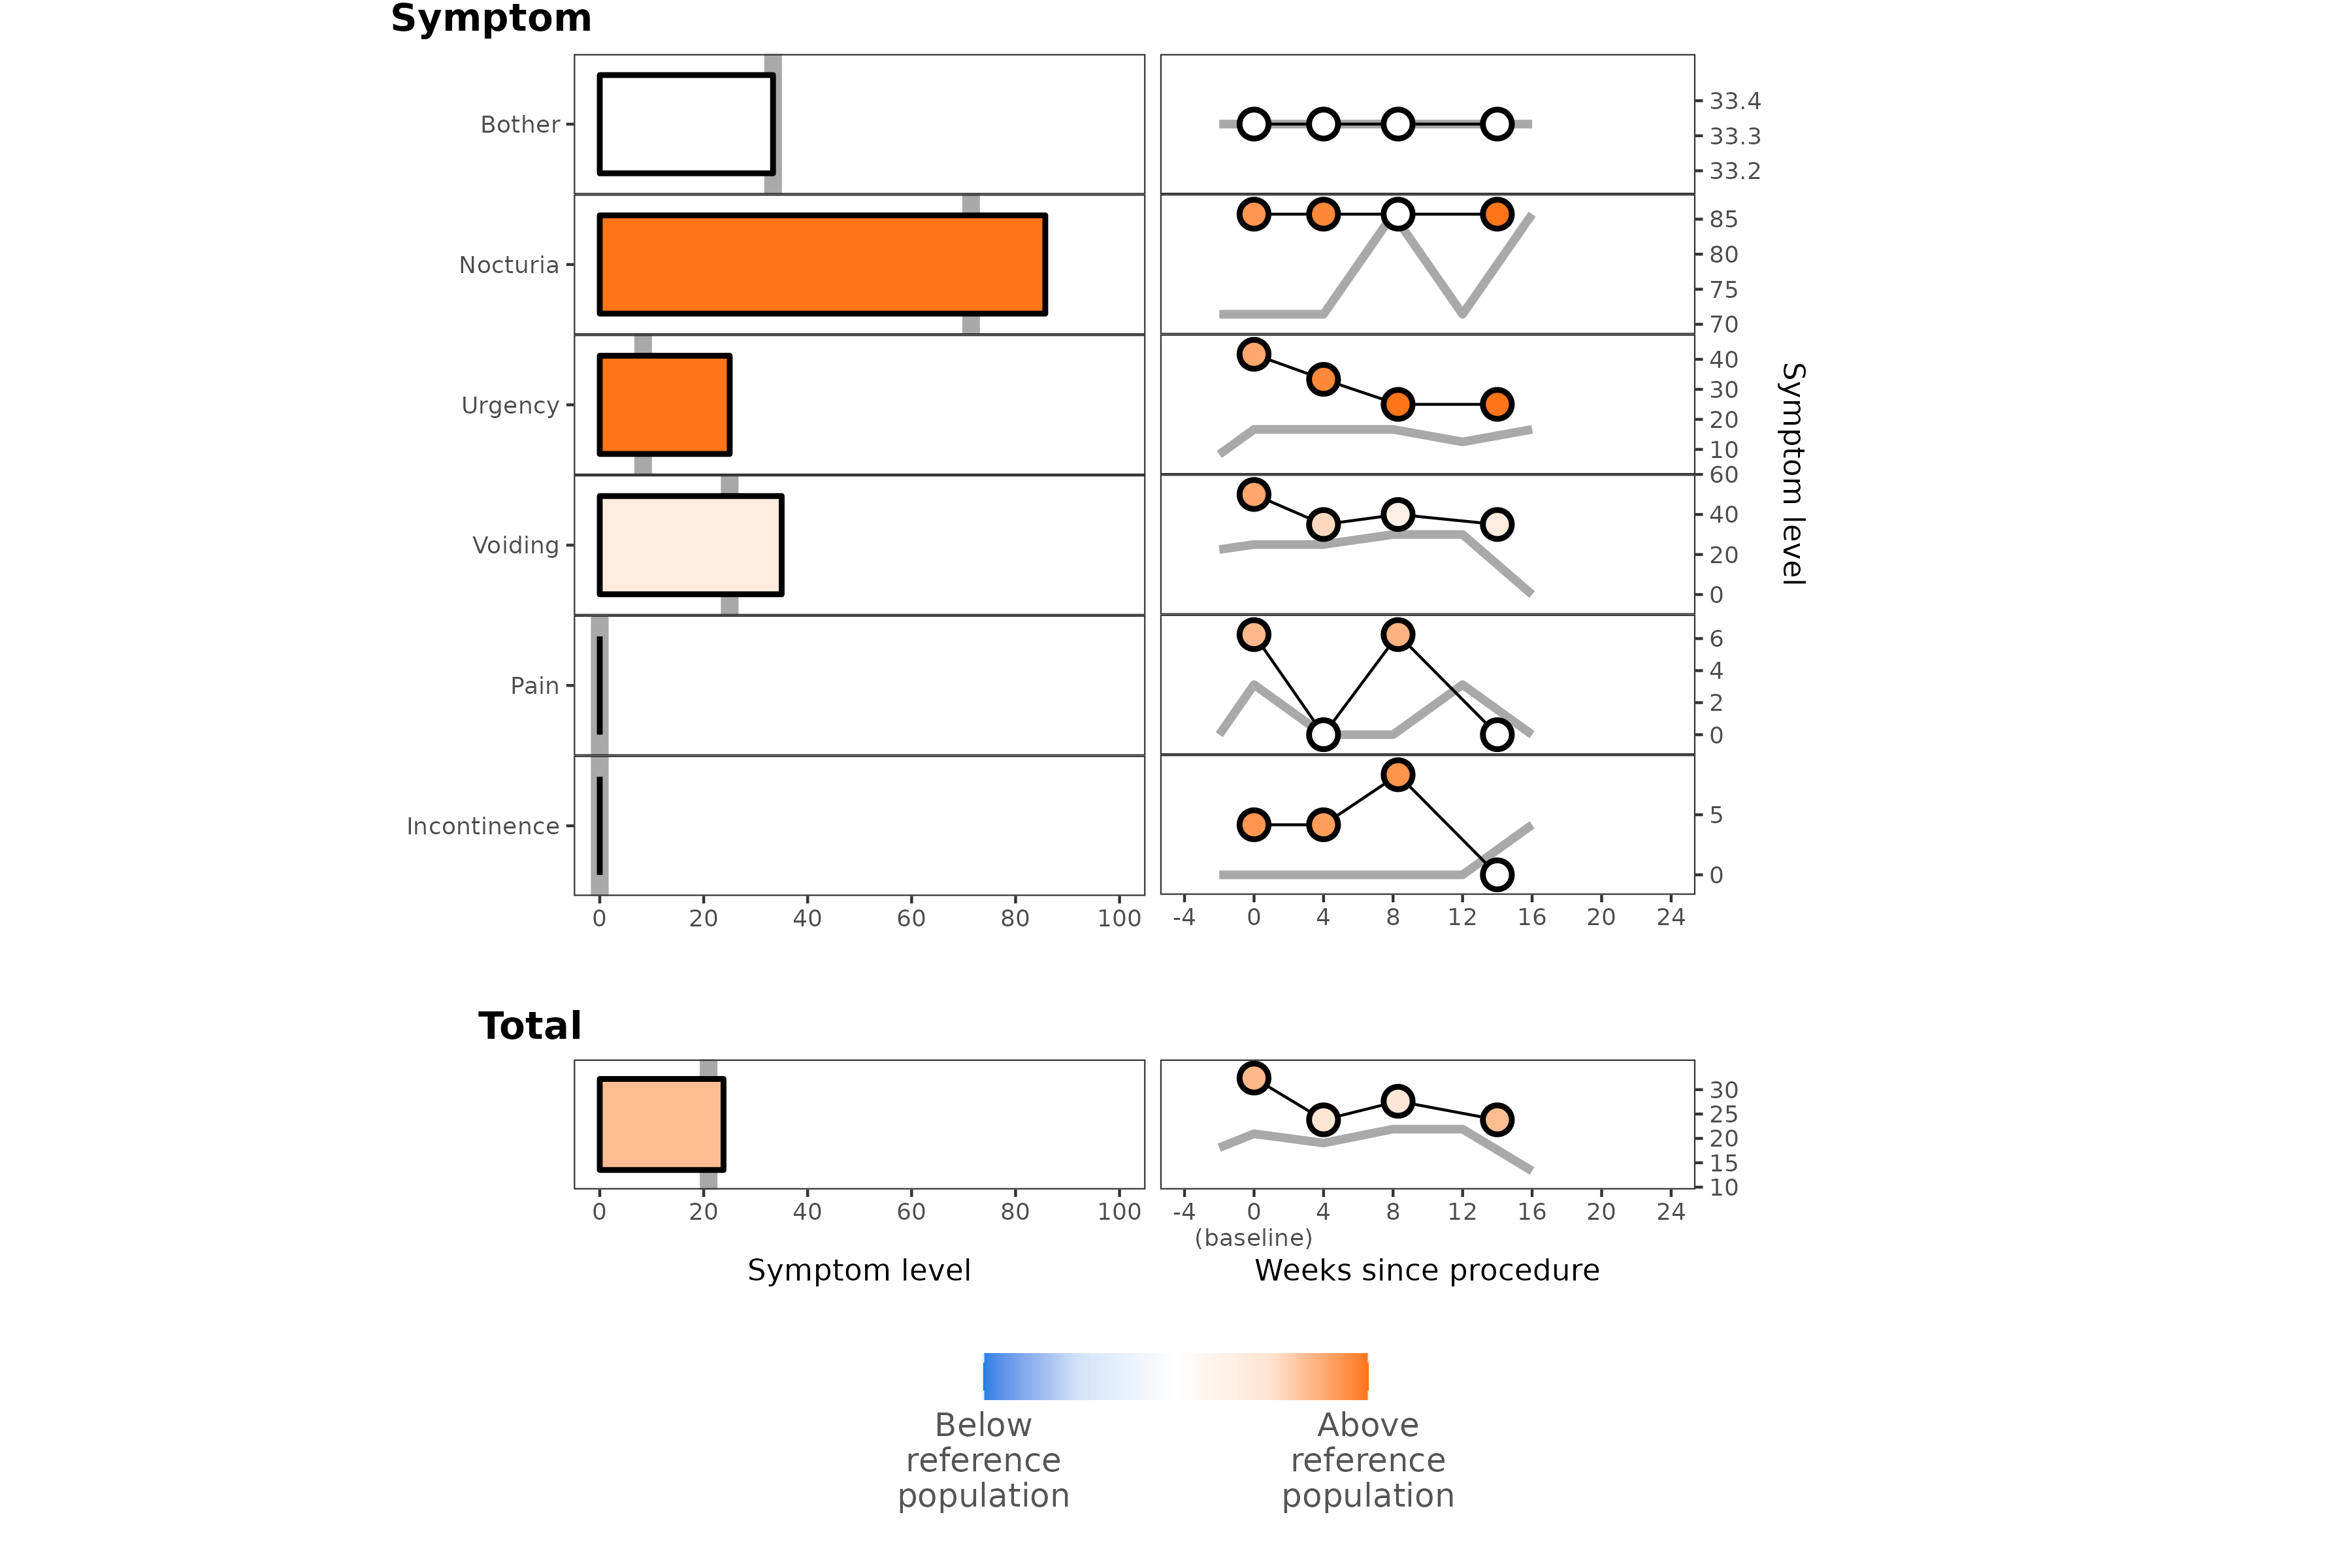

# A tibble: 1 × 7
  format width height colorspace matte filesize density  
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>    
1 PNG     3600   2400 sRGB       TRUE    278325 +118x+118

In [8]:
patient_id <- "EH22-021-002"
patient_week <- 12
study_arm <- "arm_1"

# for renaming columns
splom_vars <- c(
   "lurn_si_29_total_score", 
   "lurn_si_29_incontinence_score",
   "lurn_si_29_pain_score", 
   "lurn_si_29_voiding_score",
   "lurn_si_29_urgency_score", 
   "lurn_si_29_nocturia_score",
   "lurn_si_29_bother")
symptoms <- c("Total", 
    "Incontinence", 
    "Pain", 
    "Voiding", 
    "Urgency", 
    "Nocturia", 
    "Bother"
)
splom_vars <- rev(splom_vars)
symptoms <- rev(symptoms)

source("../flexdashboard/data_cleaning.R")
bph <- clean_real_data(read.csv("../data/EH22021EnhancedClini-LURNSI29Report_DATA_2023-09-08_1340.csv"), study_arm, patient_week)

input_params <- list(
    patient_id = patient_id, 
    patient_week = patient_week, 
    study_arm = study_arm,
    patient_row = which(bph_arm_dat_week$ID == patient_id)[1]
)

source("../flexdashboard/plotting_functions.R")

bar_chart <- create_current_week_summary_bar_chart(bph$arm_dat_week, show_density = FALSE)
line_plot <- create_time_series_line_plot(bph$arm_dat, show_density = FALSE)

g <- plot_grid(bar_chart, line_plot$plot, ncol = 2, align = "h", rel_widths = c(0.49,0.51), axis = "l")
p <- plot_grid(g, line_plot$legend, ncol = 1, rel_heights = c(1, 0.2))


# save the image and then read it back in so that I can annotate it more easily and have consistent sizing!
tmp <- tempfile("image0", fileext = ".png")
ggsave(tmp, p, width = 12, height = 8)
img <- image_read(tmp)

img

#print(paste(s,val,med,pct, percentile(med)))



week_event_number,Symptom,Median
<dbl>,<fct>,<dbl>
-2,Bother,33.333333
-2,Nocturia,71.428571
-2,Urgency,8.333333
-2,Voiding,22.500000
-2,Pain,0.000000
-2,Incontinence,0.000000
-2,Total,18.095238
0,Bother,33.333333
0,Nocturia,71.428571


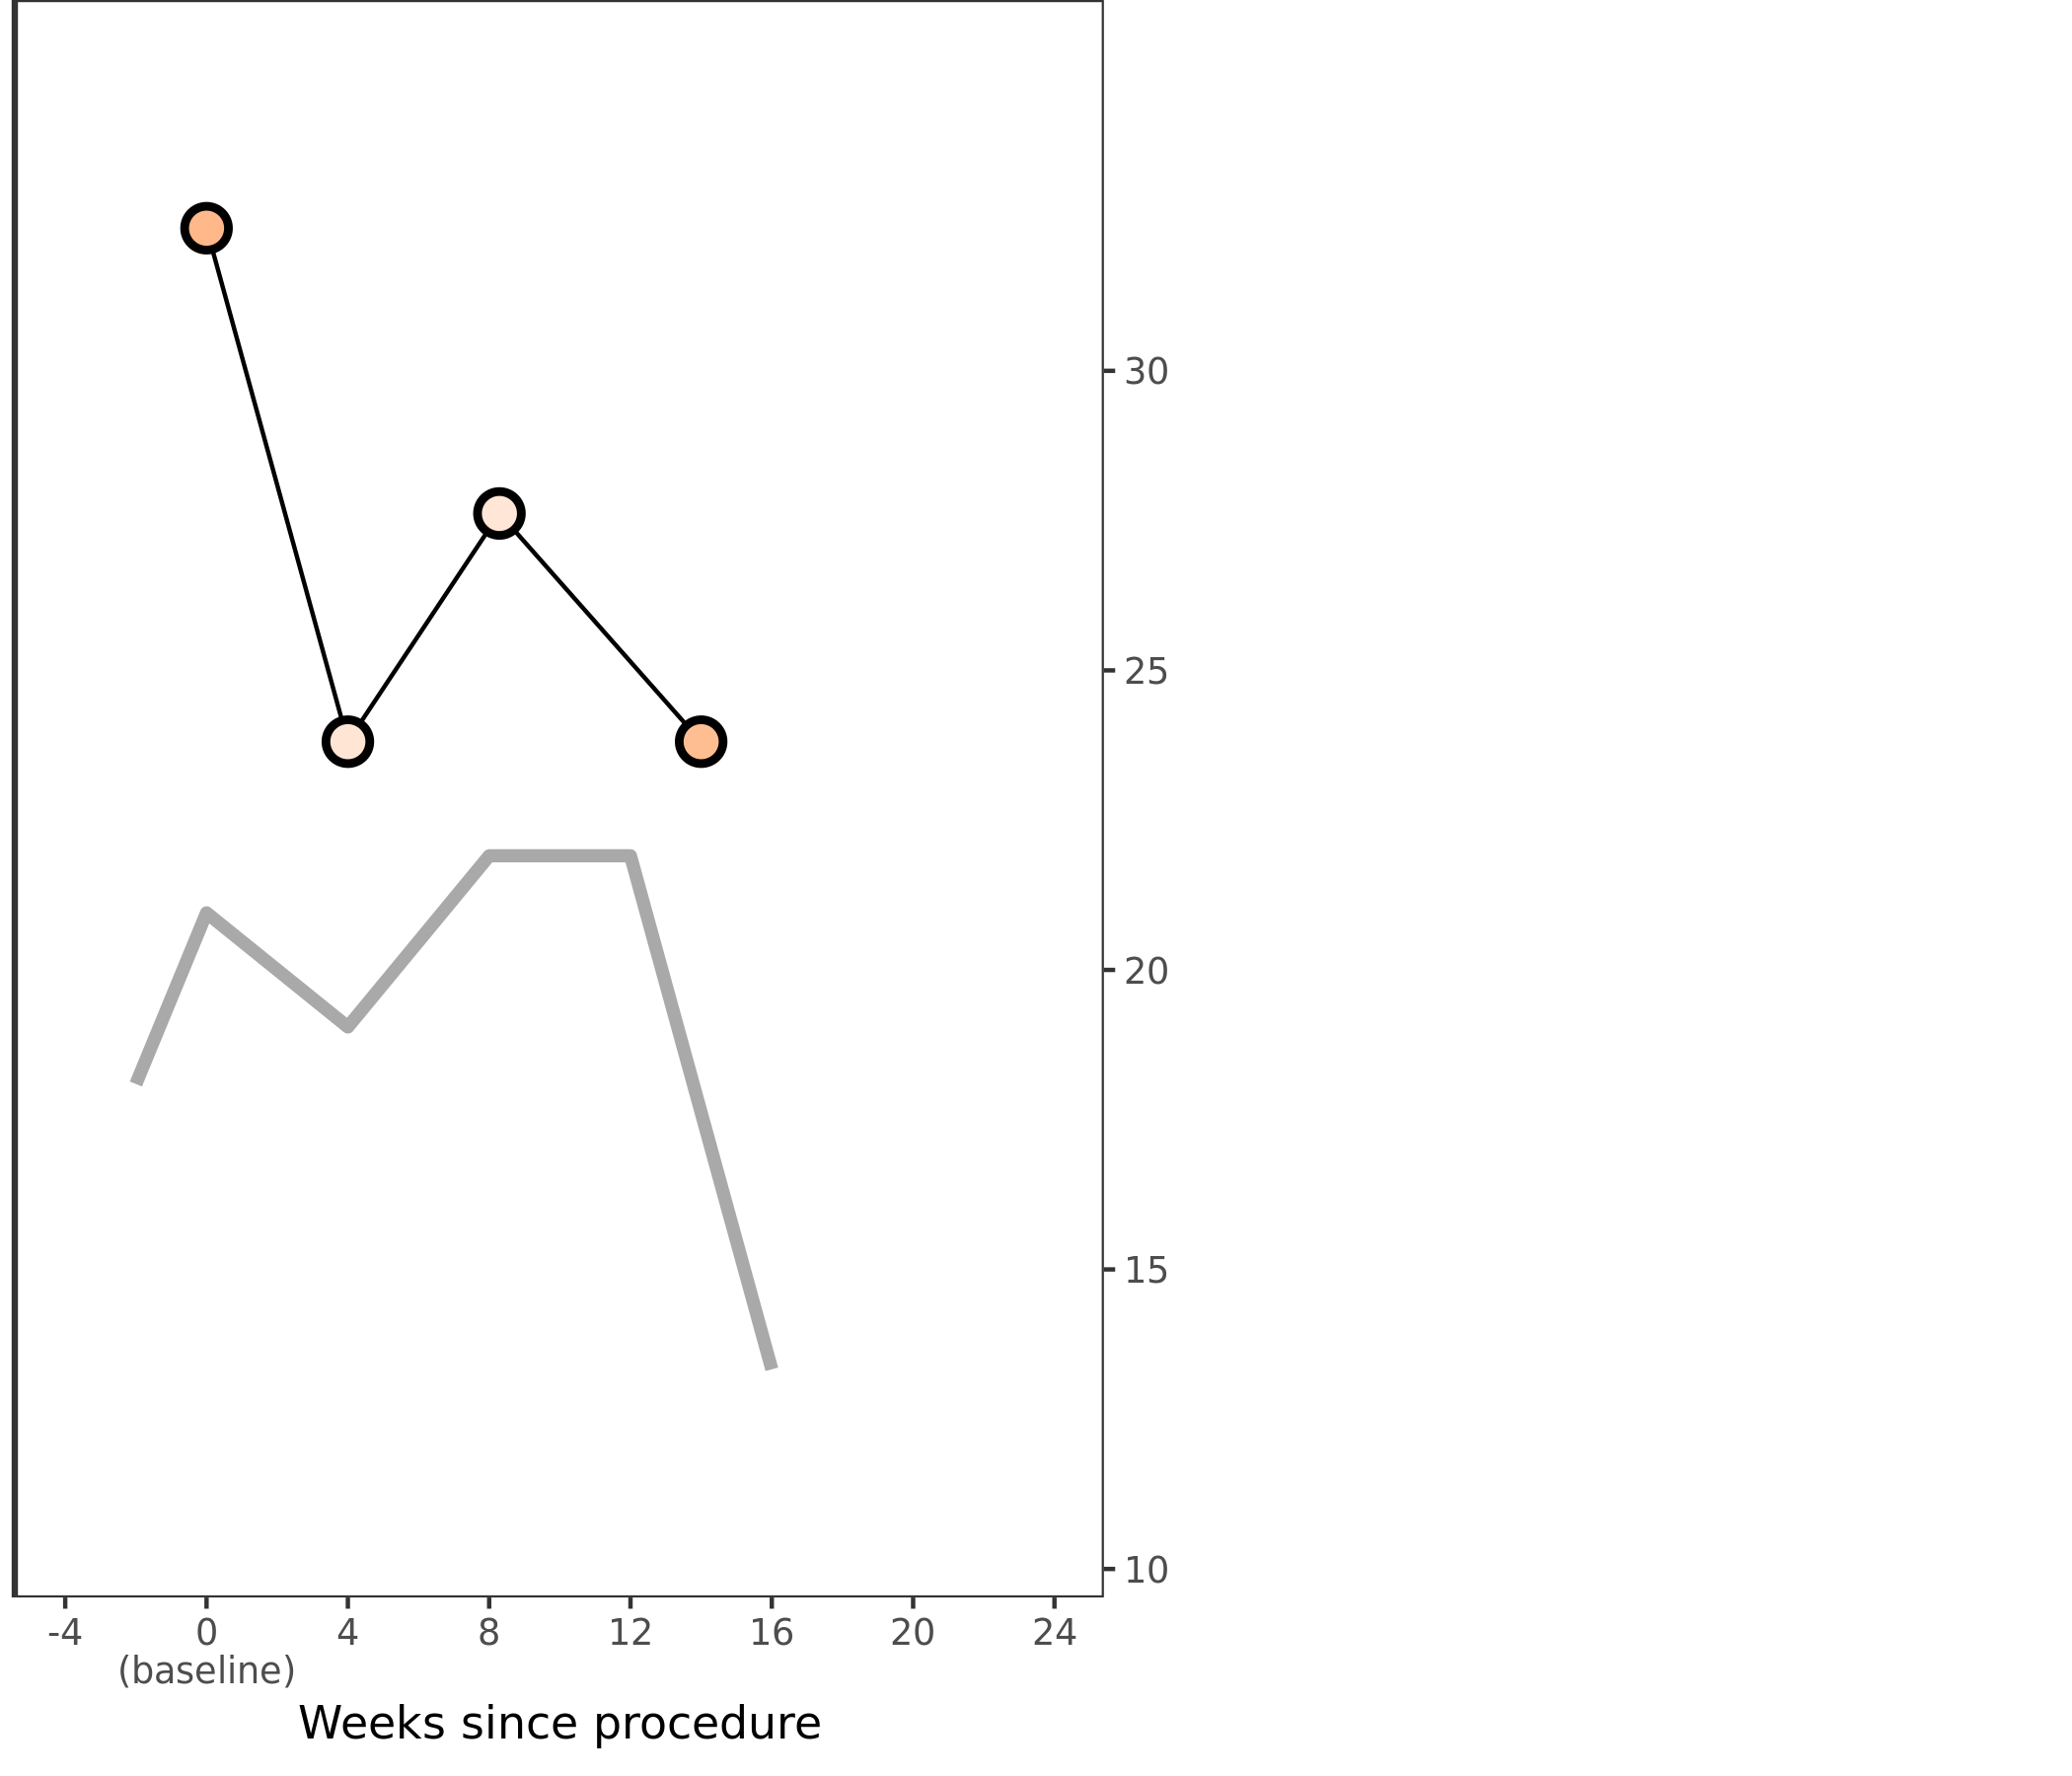

In [132]:
data_all <- bph_arm_dat
show_density <- FALSE
show_median <- TRUE

     # get the median values for the reference population 
    median_values <- data_all %>%
        group_by(week_event_number) %>%
        summarize(across(-c(ID, Week), median, na.rm = TRUE))
    median_values_t <- median_values %>%
        pivot_longer(cols = -c(week_event_number),
            names_to = "Symptom",
            values_to = "Median")

    # for the reference population
    data_all_long <- na.omit(pivot_longer(data_all, cols = c(symptoms), names_to = "Symptom", values_to = "Value"))
    data_all_long$Symptom <- factor(data_all_long$Symptom, levels = symptoms)

    # Define a custom color palette
    # custom_palette <- c("#2780E3", "white", "#ff7518")
    custom_palette <- c("#2780E3", "#D3E5F9", "white", "#FFE3D0", "#ff7518")
    # custom_palette_gray <- c("white",  "#F5F5F5", "#DCDCDC", "#B0B0B0", "#404040")
    # custom_palette_gray <- c("white",  "#F5F5F5", "#DCDCDC", "#B0B0B0", "#696969")
    custom_palette_gray <- c("white",  "#F5F5F5", "#DCDCDC", "#BEBEBE", "#888888")
    # Create a color ramp function using the custom palette
    color_ramp <- colorRamp(custom_palette)

    # Function to get an interpolated color at a specific value
    get_interpolated_color <- function(value) {
        return(rgb(color_ramp(value), maxColorValue = 255))
    }

    # get the patient data for the bar chart
    p <- select(data_all[data_all$ID == input_params$patient_id, ], -ID)
    patient_df <- p %>%
        pivot_longer(cols = -c(Week, week_event_number),
            names_to = "Symptom",
            values_to = "Value")

    # I wonder if there's a way to get the percentiles without a for loop?
    patient_df$Percentile <- 0
    patient_df$Color <- '#D3D3D3'
    for (row in 1:nrow(patient_df)) {
        val <- patient_df[row, "Value"][[1]]
        sym <- patient_df[row, "Symptom"][[1]]
        wk <- patient_df[row, "week_event_number"][[1]]
        med <- median_values[median_values$week_event_number == wk, ][[sym]]
        if (!is.nan(val) & !is.na(val)){
            ref <- data_all[data_all$week_event_number == wk, sym]
            percentile <- ecdf(ref)
            pct <- percentile(val)
            # fix for scenarios where every entry is the same
            if (diff(range(ref, na.rm = TRUE)) == 0 & pct == 1) pct <- 0.5
            # fix for scenarios where the Median is at the edge of the distribution
            if (val == med) pct <- 0.5
            patient_df[row, 'Percentile'] <- pct
            patient_df[row, 'Color'] <- get_interpolated_color(pct)
        }
    }

    # set the symptoms as a factor and in the correct order
    patient_df$Symptom <- factor(patient_df$Symptom, levels = symptoms)
    patient_df <- patient_df %>%
        mutate(srt = match(Symptom, symptoms)) %>%
        arrange(srt) %>%
        select(-srt)

    
    # add the patient info to the merged_df
    merged_df <- merge(median_values_t, patient_df, by = c("week_event_number", "Symptom")) 
    merged_df$Symptom <- factor(merged_df$Symptom, levels = symptoms)
    median_values_t$Symptom <- factor(median_values_t$Symptom, levels = symptoms)

    # omit the rows with nan values??
    merged_df_clean_limit_week <- na.omit(merged_df[merged_df$week_event_number <= input_params$patient_week, ])

    # for labelling
    breaks <- seq(-4, 24, 4)
    labels <- c("-4","0\n(baseline)", "4", "8", "12", "16", "20", "24")
    labels2 <- c("-4","0", "4", "8", "12", "16", "20", "24")

    # function to calculate custom breaks
    custom_breaks <- function(data, n_breaks = 4, tol = 0.5) {
        # Calculate better breaks based on data range
        x <- min(data, na.rm = TRUE)
        min_value <- ifelse(is.finite(x), x, 0)
        x <- max(data, na.rm = TRUE)
        max_value <- ifelse(is.finite(x), x, 100)
        breaks <- pretty(c(min_value, max_value), n = n_breaks)
        diff <- breaks[2] - breaks[1]
        top_diff <- max_value - breaks[length(breaks)]
        if (abs(top_diff/diff) > tol) {
            breaks <- breaks[1:(length(breaks) - 1)]
            if (top_diff < 0){
                breaks <- breaks[1:(length(breaks) - 1)]
            }
        }
        return(breaks)
    }


    # Calculate min and max values for each facet so that I can limit the syn_long_dat_long dataframe 
    # (and therefore the facet's y axis)
    limits <- merged_df_clean_limit_week %>%
        group_by(Symptom) %>%
        # this way the y axis scaling is fixed by the patient data and not the reference population
        # summarize(min_y = min(Value, na.rm = TRUE), max_y = max(Value, na.rm = TRUE))
        # this way, the y axis also takes into account the reference median value (so ensure that is shown)
        summarize(min_y = min(c(Value, Median), na.rm = TRUE), max_y = max(c(Value, Median), na.rm = TRUE))

    for (s in symptoms){
        ind <-  which(data_all_long$Symptom == s & data_all_long$Value > limits[limits$Symptom == s, ]$max_y*1.2)
        if (length(ind) > 0) data_all_long <- data_all_long[-ind, ]
    }

    
    # create the main plot (excluding the "Total" value)
    main <- ggplot()

    if (show_density){
        # add the density grayscale for the reference population to the figure

        # I want a way to customize the bandwidth used in the density distributions based on the min,max of the data
        custom_h <- function(lims){
            return(c(8, lims$max_y/4.))
        }
        custom_h_values <- list()
        for (s in symptoms){
            if (s != "Total") custom_h_values[[length(custom_h_values) + 1]] = custom_h(limits[limits$Symptom == s, ])
        }

        main <- main + 
            stat_density_2d(
                data = data_all_long[(data_all_long$Symptom != "Total"),],
                aes(x = week_event_number, y = Value, fill = after_stat(ndensity),),
                geom = "raster",
                position = "identity",
                h = unlist(custom_h_values),
                contour = FALSE,
                show.legend = FALSE
            ) +
            scale_fill_gradientn(
                colors = custom_palette_gray,
                values = seq(0,1,by = 1/length(custom_palette_gray)),
            ) +
            # scale_fill_gradient2(low = "white", high = "darkgray", limits = c(0., 1)) + 
            new_scale_fill()
    }

    if (show_median){
        # add the median gray line for the reference population to the figure
        main <- main +
            geom_line(
                data = median_values_t[(median_values_t$Symptom != "Total"),],
                aes(x = week_event_number, y = Median),
                color = "darkgray", 
                # linetype = "dashed", 
                size = 1.5
            )
    }

    # add the patient data to the figure and finish formatting
    main <- main +
        geom_line(
            data = merged_df_clean_limit_week[(merged_df_clean_limit_week$Symptom != "Total"),], 
            aes(x = Week, y = Value)
        ) +
        geom_point(
            data = merged_df_clean_limit_week[(merged_df_clean_limit_week$Symptom != "Total"),], 
            aes(x = Week, y = Value, fill = Color), 
            shape = 21, 
            color = "black", 
            size = 4, 
            stroke = 1.5
        ) + 
        scale_fill_identity() + 
        facet_grid(Symptom ~ ., 
            scales = "free_y", 
            switch = "both",
        ) + 
        scale_x_continuous("", breaks = breaks, labels = labels2, limits = c(-4, 24)) + 
        scale_y_continuous("Symptom level", expand = expansion(mult = c(0.2, 0.2)),
            breaks = function(x) {
                return(custom_breaks(x))
            },
            position = "right"
        ) +
        expand_limits(x = c(-1, 26)) + 
        ylab("") + 
        # theme_void() + 
        guides(fill = FALSE) +
        theme_bw() + 
        theme(
            panel.spacing = unit(0, "lines"),
            strip.text = element_text(size = 0, margin = margin(0,0,0,0)),
            plot.margin = margin(0.7, 7, 1.2, 0.1, "cm"),
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            axis.title.y.right = element_text(margin = margin(l = 10))
        ) 

    # create the total plot (including only the "Total" value)
    total <- ggplot()

    if (show_density){
        # add the density grayscale for the reference population to the figure

        # again, customize the bandwidth
        custom_h_value <- custom_h(limits[limits$Symptom == "Total", ])

        total <- total +
            stat_density_2d(
                data = data_all_long[(data_all_long$Symptom == "Total"),],
                aes(x = week_event_number, y = Value, fill = after_stat(ndensity),),
                geom = "raster",
                h = custom_h_value,
                contour = FALSE,
                show.legend = FALSE
            ) +
            scale_fill_gradientn(
                colors = custom_palette_gray,
                values = seq(0,1,by = 1/length(custom_palette_gray)),
            ) +
            # scale_fill_gradient2(low = "white", high = "darkgray", limits = c(0., 1)) + 
            new_scale_fill()
    }

    if (show_median){
        # add the median gray line for the reference population to the figure
        total <- total +    
            geom_line(
                data = median_values_t[(median_values_t$Symptom == "Total"),],
                aes(x = week_event_number, y = Median),
                color = "darkgray", 
                # linetype = "dashed", 
                size = 1.5
            )
    }

    # add the patient data to the figure and finish formatting
    total <- total +
        geom_line(
            data = merged_df_clean_limit_week[(merged_df_clean_limit_week$Symptom == "Total"),], 
            aes(x = Week, y = Value)
        ) +
        geom_point(
            data = merged_df_clean_limit_week[(merged_df_clean_limit_week$Symptom == "Total"),], 
            aes(x = Week, y = Value, fill = Color), 
            shape = 21, 
            color = "black", 
            size = 4, 
            stroke = 1.5
        ) + 
        scale_fill_identity() +   
        facet_grid(Symptom ~ ., 
            scales = "free_y", 
            switch = "both",
        ) + 
        scale_x_continuous("Weeks since procedure", breaks = breaks, labels = labels, limits = c(-4, 24)) + 
        scale_y_continuous("", expand = expansion(mult = c(0.2, 0.2)),
            breaks = function(x) {
                return(custom_breaks(x))
            },
            position = "right"
        ) +
        expand_limits(x = c(-1, 26)) + 
        ylab("") + 
        # theme_void() + 
        guides(fill = FALSE) +
        theme_bw() + 
        theme(
            strip.text = element_text(size = 0, margin = margin(0,0,0,0)),
            plot.margin = margin(0., 7, 0.25, 0.1, "cm"),
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            axis.title.y.right = element_text(margin = margin(l = 10))
        ) 

        total
median_values_t

In [ ]:
# testing differences in median ane ecdf
x <- c(1,5,3,7,9,6,23,5,7,9,6,3,76,8,6)
med <- median(x)
percentile <- ecdf(x)
print(med)
print(quantile(x, probs = 0.5, type = 8))
print(percentile(med))

In [ ]:
# Rscript -e "rmarkdown::render('SI-29_dashboard.Rmd', params = list(patient_id = 'EH22-021-001', patient_week = 12, study_arm = 'arm_1'))"